In [61]:
%run config.ipynb

import tensorflow as tf
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model, clone_model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read Datasets

In [2]:
# business = pd.read_json("data/yelp_academic_dataset_business.json", lines=True)
# check_in = pd.read_json("data/yelp_academic_dataset_checkin.json", lines=True)
# review = pd.read_csv("data/yelp_academic_dataset_sample_review.csv")
# review = pd.read_csv("data/yelp_academic_dataset_sample005_review.csv")
# tip = pd.read_json("data/yelp_academic_dataset_tip.json", lines=True)
# user = pd.read_json("data/yelp_academic_dataset_user.json", lines=True)

df = pd.read_csv("data/yelp_academic_dataset_sample005_filter.csv")
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,to_recommend,num_user_friends
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,None,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5,True,0


In [3]:
X = df["review_text_after_cleaning"]

## Split Dataset

In [4]:
y = df["review_stars"]
y = y.apply(lambda x : x - 1) # convert range(1,6) to range(0,5) for more precise when adding dense layer
# y = y.apply(lambda x : 1 if x else 0)
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Word Embedding

In [65]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [66]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 120332 unique tokens.


In [67]:
X_train = pad_sequences(sequences_train, maxlen=150)
print('Shape of data train tensor:', X_train.shape)

T = X_train.shape[1]

X_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', X_test.shape)

Shape of data train tensor: (268540, 150)
Shape of data test tensor: (132267, 150)


## Modelling

In [63]:
def fit_model(model, epochs=3, batch_size=256, loss='mse', optimizer='adam', metrics=['mae', RootMeanSquaredError('rmse')]):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    r = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    plot(r)
    return model, r

def plot(r):
    plt.xlabel('# epochs')
    length = len(r.history[next(iter(r.history))])
    plt.xticks(np.arange(length), np.arange(1, length+1))
    plt.plot(r.history['loss'], label='loss')
    plt.plot(r.history['val_loss'], label='val_loss')
    plt.plot(r.history['mae'], label='mae')
    plt.plot(r.history['val_mae'], 'm', label='val_mae')
    plt.plot(r.history['rmse'], label='rmse')
    plt.plot(r.history['val_rmse'], 'm', label='val_rmse')
    plt.legend()


def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Embedding(num_words, D))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='relu'))
    model.summary(105)
    return model

Epoch 1/3
1049/1049 [==============================] - 16s 15ms/step - loss: 1.6830 - mae: 1.0012 - mse: 1.6830 - val_loss: 0.9639 - val_mae: 0.7865 - val_mse: 0.9639
Epoch 2/3
1049/1049 [==============================] - 15s 15ms/step - loss: 0.9463 - mae: 0.7755 - mse: 0.9463 - val_loss: 0.9591 - val_mae: 0.7944 - val_mse: 0.9591
Epoch 3/3
1049/1049 [==============================] - 16s 15ms/step - loss: 0.9355 - mae: 0.7714 - mse: 0.9355 - val_loss: 0.9541 - val_mae: 0.7690 - val_mse: 0.9541


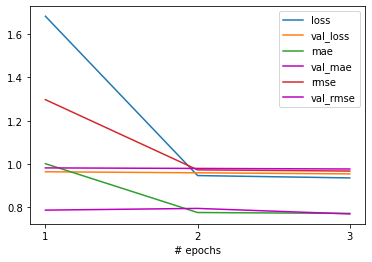

In [68]:
m, r = fit_model(create_model(), loss='mse')

Model: "sequential_21"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
embedding_21 (Embedding)                       (None, 150, 100)                          1000000         
_________________________________________________________________________________________________________
dense_50 (Dense)                               (None, 150, 16)                           1616            
_________________________________________________________________________________________________________
dropout (Dropout)                              (None, 150, 16)                           0               
_________________________________________________________________________________________________________
dense_51 (Dense)                               (None, 150, 16)                           272             
_______________________

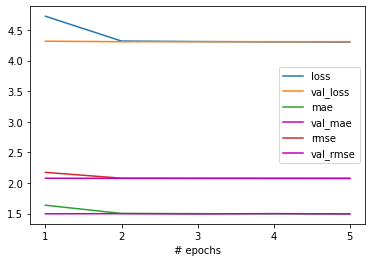

In [64]:
m1, r1 = fit_model(create_model(), epochs=5)

Model: "sequential_22"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
embedding_22 (Embedding)                       (None, 150, 100)                          2000000         
_________________________________________________________________________________________________________
dense_53 (Dense)                               (None, 150, 32)                           3232            
_________________________________________________________________________________________________________
dropout_2 (Dropout)                            (None, 150, 32)                           0               
_________________________________________________________________________________________________________
global_average_pooling1d_21 (GlobalAveragePool (None, 32)                                0               
_______________________

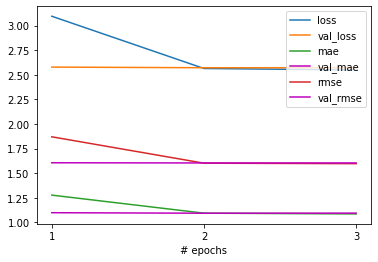

In [68]:
def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Embedding(num_words, D))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5, activation='relu'))
    model.summary(105)
    return model

m, r = fit_model(create_model())

Model: "sequential_24"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
embedding_24 (Embedding)                       (None, 150, 100)                          2000000         
_________________________________________________________________________________________________________
dense_57 (Dense)                               (None, 150, 16)                           1616            
_________________________________________________________________________________________________________
dropout_4 (Dropout)                            (None, 150, 16)                           0               
_________________________________________________________________________________________________________
global_average_pooling1d_23 (GlobalAveragePool (None, 16)                                0               
_______________________

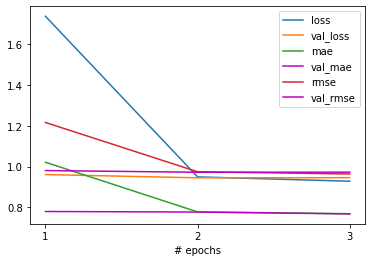

In [70]:
def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Embedding(num_words, D))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5))
    model.summary(105)
    return model

m, r = fit_model(create_model())

Model: "sequential_25"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
embedding_25 (Embedding)                       (None, 150, 100)                          2000000         
_________________________________________________________________________________________________________
dense_59 (Dense)                               (None, 150, 16)                           1616            
_________________________________________________________________________________________________________
dropout_5 (Dropout)                            (None, 150, 16)                           0               
_________________________________________________________________________________________________________
global_max_pooling1d (GlobalMaxPooling1D)      (None, 16)                                0               
_______________________

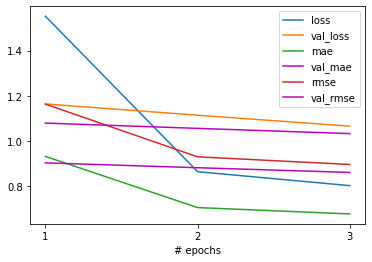

In [71]:
def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Embedding(num_words, D))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(5))
    model.summary(105)
    return model

m, r = fit_model(create_model())

Model: "sequential_26"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
embedding_26 (Embedding)                       (None, 150, 100)                          2000000         
_________________________________________________________________________________________________________
dense_61 (Dense)                               (None, 150, 16)                           1616            
_________________________________________________________________________________________________________
dropout_6 (Dropout)                            (None, 150, 16)                           0               
_________________________________________________________________________________________________________
dense_62 (Dense)                               (None, 150, 16)                           272             
_______________________

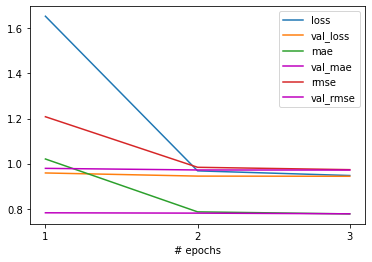

In [72]:
def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Embedding(num_words, D))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5))
    model.summary(105)
    return model

m, r = fit_model(create_model())

Model: "sequential_27"
_________________________________________________________________________________________________________
Layer (type)                                   Output Shape                              Param #         
embedding_27 (Embedding)                       (None, 150, 100)                          2000000         
_________________________________________________________________________________________________________
dense_64 (Dense)                               (None, 150, 16)                           1616            
_________________________________________________________________________________________________________
dropout_8 (Dropout)                            (None, 150, 16)                           0               
_________________________________________________________________________________________________________
dense_65 (Dense)                               (None, 150, 8)                            136             
_______________________

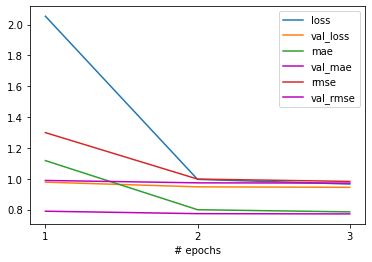

In [73]:
def create_model():
    D = 100
    num_words = min(MAX_VOCAB_SIZE, V + 1)
    model = Sequential()
    model.add(Input(shape=(T,)))
    model.add(Embedding(num_words, D))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(5))
    model.summary(105)
    return model

m, r = fit_model(create_model())